In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
import network
import environment
import numpy as np

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
def memory_queue(memory,weight):
    weight = np.expand_dims(weight.T,axis=1)
    memory = np.concatenate((weight,memory),axis=2)[:,:,:-1]
    return memory

def MM_scaler(s):
    x= np.zeros(s.shape)
    for i in range(len(s)):
        x[i]=(s[i]-np.min(s[i],axis=0))/((np.max(s[i],axis=0)-np.min(s[i],axis=0))+1e-5)
    return x

def calculate_SV(value_list):
    value_array = np.array(value_list)/money
    return_array = np.log(value_array[1:]/value_array[:-1])
    SV=np.sqrt(np.var(return_array))
    SV = SV*np.sqrt(period)
    return SV

def sharpe_ratio(value_list,kospi):
    value_array = np.array(value_list)
    sigma = calculate_SV(value_list)
    APV = value_array[-1]
    excess_return = APV-kospi[-1]/kospi[0]
    sharpe_ratio = excess_return/sigma
    return sharpe_ratio
    
def beta(value,kospi):
    return_array = np.log(value[1:]/value[:-1])
    return_kospi = np.log(kospi[1:]/kospi[:-1])
    cov = np.cov(return_array,return_kospi)
    beta = cov[0,1]/cov[1,1]
    return beta

def MDD(apv):
    apv_max=[]
    apv_min=[]
    for i in range(1,period):
        apv_max.append(np.max(apv[:i]))
        apv_min.append(np.min(apv[np.argmax(apv[:i]):i]))
    drawdown = (np.array(apv_max) - np.array(apv_min))/np.array(apv_max)
    return drawdown

In [3]:
#preprocessed data loading
is_train = 0

#hyperparameters
input_day_size = 50
filter_size = 3
num_of_feature = 4
num_of_asset = 12
num_episodes = 10000 if is_train ==1 else 1
test_episodes = 2000
money = 1e+8
period = 1019 if is_train else 275

#saving
save_frequency = 100
save_path = './weights/'
save_model = 1
load_model = 1
selecting_random = False

env = environment.env(train = 0, number_of_asset = num_of_asset)

In [4]:
config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True

In [5]:
a_loss_sum = 0
s_loss_sum = 0
value_deque = deque()
AAM_deque = deque()

In [6]:
sess = tf.Session(config = config)

with tf.variable_scope('AAM'):
    allocator=network.policy(sess,num_of_asset = num_of_asset)
with tf.variable_scope('ESM'):    
    selector = network.select_network(sess)

sess.run(tf.global_variables_initializer())

saver_AAM = tf.train.Saver(var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'AAM'),max_to_keep=100)
ckpt_AAM = tf.train.get_checkpoint_state(save_path+'AAM/m_'+str(num_of_asset))
saver_ESM = tf.train.Saver(var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'ESM'),max_to_keep=100)
ckpt_ESM = tf.train.get_checkpoint_state(save_path+'ESM')

if load_model:
    saver_AAM.restore(sess,ckpt_AAM.model_checkpoint_path)
    saver_ESM.restore(sess,ckpt_ESM.model_checkpoint_path)

Device mapping:


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from ./weights/AAM/m_12\AAM-4999.cptk
INFO:tensorflow:Restoring parameters from ./weights/ESM\ESM-4999.cptk


In [7]:
score = 0
for i in range(num_episodes):
    allocator_memory = deque()
    selector_memory = deque()
    s=env.start()
    s=MM_scaler(s)
    done=False
    v=money
    weight_memory = []
    value_list = []
    bench_list = []
    while not done:
        evaluated_value = selector.predict(s)
        selected_s = env.selecting(evaluated_value,rand=selecting_random)
        selected_s = MM_scaler(selected_s)
        w = allocator.predict(selected_s)
        s_prime,r,done,v_prime,growth = env.action(w)
        s_prime=MM_scaler(s_prime)
        weight_memory.append(w)
        s = s_prime
        v = v_prime
        value_list.append(v)
        bench_list.append(env.benchmark)
        if done:
            value_deque.append(['AAM+ESM',value_list])
            value_deque.append(['ESM only',bench_list])
            score+=v/money
            print(i,'agent:',round(v/money,4), 'benchmark:',round(env.benchmark/money,4))

0 agent: 1.6903 benchmark: 1.6991


In [8]:
for i in range(test_episodes):
    value_list = []
    allocator_memory = deque()
    s=env.start()
    s = MM_scaler(s)
    done = False
    v = money
    while not done:
        selected_s = env.selecting(evaluated_value, rand = True)
        selected_s = MM_scaler(selected_s)
        w = allocator.predict(selected_s)
        s_prime,r,done,v_prime,growth = env.action(w)
        s_prime = MM_scaler(s_prime)
        s = s_prime
        v = v_prime
        value_list.append(v)
        if done:
            AAM_deque.append(value_list)
            score+=v/money
            print(i,'agent:',round(v/money,4), 'benchmark:',round(env.benchmark/money,4))

0 agent: 0.9829 benchmark: 0.9684
1 agent: 1.3856 benchmark: 1.3707
2 agent: 1.2907 benchmark: 1.271
3 agent: 1.013 benchmark: 1.0033
4 agent: 1.1649 benchmark: 1.1704
5 agent: 1.2663 benchmark: 1.2795
6 agent: 1.0579 benchmark: 1.052
7 agent: 0.9913 benchmark: 1.0189
8 agent: 1.2663 benchmark: 1.2474
9 agent: 1.2454 benchmark: 1.235
10 agent: 1.2383 benchmark: 1.2546
11 agent: 1.315 benchmark: 1.3357
12 agent: 0.9983 benchmark: 1.0013
13 agent: 1.5141 benchmark: 1.5358
14 agent: 0.9504 benchmark: 0.9775
15 agent: 1.0468 benchmark: 1.0611
16 agent: 1.8145 benchmark: 1.7241
17 agent: 1.4429 benchmark: 1.4433
18 agent: 1.3749 benchmark: 1.3516
19 agent: 1.248 benchmark: 1.2064
20 agent: 0.993 benchmark: 0.965
21 agent: 1.1816 benchmark: 1.1993
22 agent: 1.1261 benchmark: 1.1196
23 agent: 1.1276 benchmark: 1.1378
24 agent: 1.3433 benchmark: 1.3255
25 agent: 1.3124 benchmark: 1.3387
26 agent: 1.0578 benchmark: 1.0606
27 agent: 1.1609 benchmark: 1.1619
28 agent: 1.3463 benchmark: 1.3381
29 

232 agent: 1.2756 benchmark: 1.2315
233 agent: 1.2633 benchmark: 1.2615
234 agent: 1.3518 benchmark: 1.3432
235 agent: 2.1597 benchmark: 2.0526
236 agent: 1.0774 benchmark: 1.0855
237 agent: 1.1915 benchmark: 1.1917
238 agent: 1.0603 benchmark: 1.0662
239 agent: 1.2219 benchmark: 1.2307
240 agent: 1.4182 benchmark: 1.4464
241 agent: 1.1633 benchmark: 1.1771
242 agent: 0.9464 benchmark: 0.9624
243 agent: 1.1871 benchmark: 1.1617
244 agent: 0.8857 benchmark: 0.8763
245 agent: 1.3463 benchmark: 1.3664
246 agent: 1.1633 benchmark: 1.1748
247 agent: 1.205 benchmark: 1.2332
248 agent: 1.4666 benchmark: 1.4972
249 agent: 1.0198 benchmark: 1.0164
250 agent: 0.9626 benchmark: 0.9977
251 agent: 1.4177 benchmark: 1.4304
252 agent: 1.0378 benchmark: 1.0578
253 agent: 1.2801 benchmark: 1.3094
254 agent: 1.1182 benchmark: 1.1479
255 agent: 1.3614 benchmark: 1.3674
256 agent: 1.0842 benchmark: 1.0518
257 agent: 1.0906 benchmark: 1.0973
258 agent: 1.0694 benchmark: 1.1088
259 agent: 1.4516 benchmark: 

461 agent: 1.203 benchmark: 1.1962
462 agent: 1.2139 benchmark: 1.222
463 agent: 1.1314 benchmark: 1.1194
464 agent: 2.2257 benchmark: 2.1077
465 agent: 0.8888 benchmark: 0.895
466 agent: 1.3855 benchmark: 1.3765
467 agent: 0.8744 benchmark: 0.8761
468 agent: 1.5514 benchmark: 1.5228
469 agent: 1.2149 benchmark: 1.2433
470 agent: 1.4061 benchmark: 1.398
471 agent: 0.9659 benchmark: 0.9669
472 agent: 1.3229 benchmark: 1.3136
473 agent: 1.1301 benchmark: 1.1323
474 agent: 0.9889 benchmark: 0.9882
475 agent: 1.0613 benchmark: 1.0742
476 agent: 1.0085 benchmark: 1.0304
477 agent: 1.2455 benchmark: 1.27
478 agent: 1.0412 benchmark: 1.0232
479 agent: 1.1523 benchmark: 1.1614
480 agent: 1.2636 benchmark: 1.2822
481 agent: 1.1788 benchmark: 1.1731
482 agent: 1.2311 benchmark: 1.2695
483 agent: 1.1409 benchmark: 1.1589
484 agent: 1.2662 benchmark: 1.2516
485 agent: 1.3676 benchmark: 1.3956
486 agent: 1.2107 benchmark: 1.2106
487 agent: 1.1601 benchmark: 1.1784
488 agent: 1.202 benchmark: 1.1907

690 agent: 0.9479 benchmark: 0.9614
691 agent: 1.4526 benchmark: 1.4388
692 agent: 1.2643 benchmark: 1.269
693 agent: 1.2711 benchmark: 1.2284
694 agent: 1.1319 benchmark: 1.1213
695 agent: 1.1372 benchmark: 1.1329
696 agent: 1.0598 benchmark: 1.0768
697 agent: 1.1754 benchmark: 1.1644
698 agent: 0.9812 benchmark: 0.9737
699 agent: 1.4617 benchmark: 1.4739
700 agent: 1.2262 benchmark: 1.217
701 agent: 0.9862 benchmark: 0.9655
702 agent: 0.9841 benchmark: 1.0028
703 agent: 1.3788 benchmark: 1.3869
704 agent: 1.222 benchmark: 1.2369
705 agent: 1.2056 benchmark: 1.1803
706 agent: 1.2052 benchmark: 1.1931
707 agent: 1.0791 benchmark: 1.0685
708 agent: 1.0832 benchmark: 1.1144
709 agent: 1.185 benchmark: 1.1595
710 agent: 2.0528 benchmark: 1.9133
711 agent: 1.9769 benchmark: 1.8182
712 agent: 1.114 benchmark: 1.1014
713 agent: 1.1835 benchmark: 1.1697
714 agent: 1.9535 benchmark: 1.8848
715 agent: 1.2118 benchmark: 1.1939
716 agent: 1.373 benchmark: 1.3723
717 agent: 1.2786 benchmark: 1.259

919 agent: 2.6888 benchmark: 2.4916
920 agent: 1.0165 benchmark: 1.0316
921 agent: 1.246 benchmark: 1.2163
922 agent: 1.193 benchmark: 1.2083
923 agent: 1.1336 benchmark: 1.1431
924 agent: 1.3804 benchmark: 1.4044
925 agent: 1.1445 benchmark: 1.1676
926 agent: 1.0599 benchmark: 1.084
927 agent: 1.301 benchmark: 1.2994
928 agent: 1.2029 benchmark: 1.1978
929 agent: 1.2367 benchmark: 1.2543
930 agent: 1.0088 benchmark: 0.9908
931 agent: 1.2041 benchmark: 1.1944
932 agent: 1.3725 benchmark: 1.3486
933 agent: 1.2304 benchmark: 1.2348
934 agent: 1.1762 benchmark: 1.2086
935 agent: 1.3173 benchmark: 1.2913
936 agent: 1.0716 benchmark: 1.0591
937 agent: 0.9696 benchmark: 0.9883
938 agent: 1.1774 benchmark: 1.1728
939 agent: 1.1386 benchmark: 1.1146
940 agent: 1.0617 benchmark: 1.0596
941 agent: 2.0554 benchmark: 2.1083
942 agent: 1.1858 benchmark: 1.2095
943 agent: 1.0519 benchmark: 1.0713
944 agent: 1.1706 benchmark: 1.1565
945 agent: 1.1748 benchmark: 1.2156
946 agent: 1.1657 benchmark: 1.1

1145 agent: 1.0762 benchmark: 1.1051
1146 agent: 1.9485 benchmark: 2.0514
1147 agent: 1.2126 benchmark: 1.2105
1148 agent: 1.2555 benchmark: 1.2436
1149 agent: 1.1638 benchmark: 1.1516
1150 agent: 1.1173 benchmark: 1.132
1151 agent: 1.3046 benchmark: 1.3299
1152 agent: 1.4735 benchmark: 1.4106
1153 agent: 1.194 benchmark: 1.1786
1154 agent: 1.4539 benchmark: 1.4586
1155 agent: 1.102 benchmark: 1.115
1156 agent: 1.0468 benchmark: 1.0384
1157 agent: 1.579 benchmark: 1.497
1158 agent: 1.1566 benchmark: 1.1206
1159 agent: 1.3575 benchmark: 1.3253
1160 agent: 1.0913 benchmark: 1.1267
1161 agent: 1.1162 benchmark: 1.0998
1162 agent: 2.3714 benchmark: 2.2569
1163 agent: 0.9762 benchmark: 0.9761
1164 agent: 2.1528 benchmark: 2.0508
1165 agent: 1.2842 benchmark: 1.2874
1166 agent: 1.1394 benchmark: 1.1403
1167 agent: 1.1018 benchmark: 1.062
1168 agent: 1.0858 benchmark: 1.1209
1169 agent: 0.9661 benchmark: 0.9782
1170 agent: 1.418 benchmark: 1.4661
1171 agent: 0.9425 benchmark: 0.9597
1172 agen

1368 agent: 1.1315 benchmark: 1.1388
1369 agent: 1.2308 benchmark: 1.2534
1370 agent: 1.3128 benchmark: 1.2977
1371 agent: 1.1713 benchmark: 1.1487
1372 agent: 1.0367 benchmark: 1.0328
1373 agent: 1.0808 benchmark: 1.09
1374 agent: 1.3416 benchmark: 1.3236
1375 agent: 2.5306 benchmark: 2.4451
1376 agent: 1.1342 benchmark: 1.1093
1377 agent: 1.0562 benchmark: 1.0962
1378 agent: 1.2302 benchmark: 1.2656
1379 agent: 1.4017 benchmark: 1.3666
1380 agent: 1.3804 benchmark: 1.3843
1381 agent: 1.0268 benchmark: 0.9948
1382 agent: 1.3703 benchmark: 1.3593
1383 agent: 1.2428 benchmark: 1.1938
1384 agent: 1.027 benchmark: 1.0709
1385 agent: 1.1158 benchmark: 1.1343
1386 agent: 1.2128 benchmark: 1.2166
1387 agent: 1.6593 benchmark: 1.68
1388 agent: 1.5417 benchmark: 1.5036
1389 agent: 1.1787 benchmark: 1.1637
1390 agent: 1.366 benchmark: 1.3322
1391 agent: 0.9323 benchmark: 0.9463
1392 agent: 1.0999 benchmark: 1.0777
1393 agent: 1.0839 benchmark: 1.1247
1394 agent: 1.4418 benchmark: 1.4704
1395 ag

1591 agent: 1.1297 benchmark: 1.1158
1592 agent: 1.2731 benchmark: 1.2825
1593 agent: 1.1264 benchmark: 1.148
1594 agent: 1.0529 benchmark: 1.0288
1595 agent: 1.0589 benchmark: 1.0682
1596 agent: 1.1723 benchmark: 1.1496
1597 agent: 1.1032 benchmark: 1.1432
1598 agent: 0.9729 benchmark: 0.98
1599 agent: 1.3403 benchmark: 1.3055
1600 agent: 1.4034 benchmark: 1.3745
1601 agent: 1.3973 benchmark: 1.3807
1602 agent: 1.2805 benchmark: 1.283
1603 agent: 0.9874 benchmark: 0.9807
1604 agent: 1.0201 benchmark: 1.0276
1605 agent: 1.4092 benchmark: 1.3909
1606 agent: 1.9153 benchmark: 1.9973
1607 agent: 1.147 benchmark: 1.1636
1608 agent: 1.1969 benchmark: 1.184
1609 agent: 1.071 benchmark: 1.0633
1610 agent: 0.9175 benchmark: 0.9057
1611 agent: 1.1266 benchmark: 1.1135
1612 agent: 1.027 benchmark: 1.0256
1613 agent: 1.1414 benchmark: 1.1379
1614 agent: 1.1919 benchmark: 1.1903
1615 agent: 1.2295 benchmark: 1.237
1616 agent: 0.9494 benchmark: 0.9549
1617 agent: 1.1796 benchmark: 1.1825
1618 agent

1815 agent: 1.1094 benchmark: 1.09
1816 agent: 1.0767 benchmark: 1.0707
1817 agent: 1.1692 benchmark: 1.1743
1818 agent: 0.9073 benchmark: 0.9107
1819 agent: 1.1448 benchmark: 1.0929
1820 agent: 2.3031 benchmark: 2.2207
1821 agent: 1.0835 benchmark: 1.0791
1822 agent: 1.0936 benchmark: 1.0684
1823 agent: 1.529 benchmark: 1.554
1824 agent: 1.2207 benchmark: 1.2577
1825 agent: 1.1863 benchmark: 1.1992
1826 agent: 1.335 benchmark: 1.3198
1827 agent: 1.2556 benchmark: 1.2805
1828 agent: 2.1387 benchmark: 2.3049
1829 agent: 1.1131 benchmark: 1.1231
1830 agent: 1.2153 benchmark: 1.2399
1831 agent: 1.1461 benchmark: 1.1681
1832 agent: 1.0919 benchmark: 1.1033
1833 agent: 1.3244 benchmark: 1.3037
1834 agent: 1.415 benchmark: 1.4127
1835 agent: 1.0602 benchmark: 1.0709
1836 agent: 1.1664 benchmark: 1.1613
1837 agent: 1.2494 benchmark: 1.233
1838 agent: 1.1576 benchmark: 1.1683
1839 agent: 1.3217 benchmark: 1.3622
1840 agent: 1.3931 benchmark: 1.3666
1841 agent: 1.2414 benchmark: 1.2491
1842 age

In [9]:
import benchmark
import pandas as pd

value_array = np.array(value_deque[0][1])
ESM_value_array = np.array(value_deque[1][1])
AAM_mean_deque = deque()
AAM_array = np.array(AAM_deque)
for i in range(env.time):
    AAM_mean_deque.append(np.mean(AAM_array[:,i]))
AAM_mean_array = np.array(AAM_mean_deque)
AAM_mean_array

k200price = pd.read_csv("./data/KOSPI200index.csv")
k200 = k200price[['종가']].to_numpy(dtype=np.float32)
k200 = k200[1:-1]
k200 = k200[::-1]

benchmark = benchmark.benchmark(num_of_asset = num_of_asset)
ucrp,ubah = benchmark.execute(iteration=test_episodes)
UCRP = np.mean(ucrp,axis = 0)
UBAH = np.mean(ubah,axis = 0)

best = env.env_data.loaded_list[86][50:-1,0]
best = best/env.env_data.loaded_list[86][49,0]

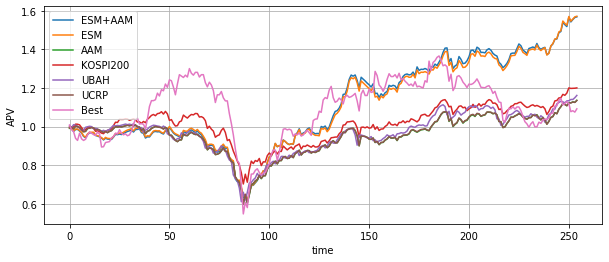

In [10]:
plt.figure(figsize = (10,4))
plt.grid(1)
plt.plot(value_array[:-19]/money,label='ESM+AAM')
plt.plot(ESM_value_array[:-19]/money,label = 'ESM')
plt.plot(AAM_mean_array[:-19]/money,label = 'AAM')
plt.plot(k200[:-19]/k200[0],label='KOSPI200')
plt.plot(UBAH[:-19]/money,label = 'UBAH')
plt.plot(UCRP[:-19]/money,label = 'UCRP')
plt.plot(best[:-19],label = 'Best')
plt.xlabel("time")
plt.ylabel("APV")
plt.legend()
plt.show()

In [11]:
value_array= value_array[:-19]
ESM_value_array = ESM_value_array[:-19]
AAM_mean_array = AAM_mean_array[:-19]
k200 = k200[:-19]
UBAH = UBAH[:-19]
UCRP = UCRP[:-19]
best = best[:-19]

base_rate = np.array(np.loadtxt('./data/base_rate_test.csv',delimiter=',',dtype = str)[1:][:,1],dtype =np.float32)

In [12]:
print('esm+aam:',np.max(MDD(value_array/money)))
print('aam:',np.max(MDD(ESM_value_array/money)))

mdd_ucrp_list = []    
for i in ucrp:
    mdd_ucrp_list.append(np.max(MDD(i[:-19]/money)))
print('ucrp:',np.mean(np.array(mdd_ucrp_list)))

mdd_ubah_list = []
for i in ubah:
    mdd_ubah_list.append(np.max(MDD(i[:-19]/money)))
    
print('ubah:',np.mean(np.array(mdd_ubah_list)))

mdd_aam_list=[]
for i in AAM_array:
    mdd_aam_list.append(np.max(MDD(i[:-19]/money)))
    
print('aam:',np.mean(np.array(mdd_aam_list)))

esm+aam: 0.38780892
aam: 0.3833727
ucrp: 0.41628033
ubah: 0.40975
aam: 0.41929385


In [13]:
print('ksp:',k200[-1]/k200[0])
print('best:',best[-1])
print('esm+aam:',value_array[-1]/money)
print('esm:',ESM_value_array[-1]/money)
print('ucrp:',UCRP[-1]/money)
print('ubah:',UBAH[-1]/money)
print('aam:',AAM_mean_array[-1]/money)

ksp: [1.2008461]
best: 1.0922331
esm+aam: 1.56926496
esm: 1.57245312
ucrp: 1.13544064
ubah: 1.16187024
aam: 1.1365532


In [16]:
print('ESM+aam:',calculate_SV(value_array))
print('ESM:',calculate_SV(ESM_value_array))
print('best:',calculate_SV(best))
print('ksp:',calculate_SV(k200/k200[0]))

sv_ucrp_list = []    
for i in ucrp:
    sv_ucrp_list.append(calculate_SV(i[:-19]/money))
print('ucrp:',np.mean(np.array(sv_ucrp_list)))

sv_ubah_list = []
for i in ubah:
    sv_ubah_list.append(calculate_SV(i[:-19]/money))
    
print('ubah:',np.mean(np.array(sv_ubah_list)))

sv_aam_list=[]
for i in AAM_array:
    sv_aam_list.append(calculate_SV(i[:-19]/money))
    
print('aam:',np.mean(np.array(sv_aam_list)))

ESM+aam: 0.33042860058446194
ESM: 0.3256421224383571
best: 0.5775155848550355
ksp: 0.2940536833097194
ucrp: 0.3470724105215082
ubah: 0.35501933613251024
aam: 0.349345226842315


In [15]:
Rf = [1.0,1.008]
print(sharpe_ratio(value_array/money,Rf))
print(sharpe_ratio(ESM_value_array/money,Rf))

sr_ubah_list = []    
for i in ubah:
    sr_ubah_list.append(sharpe_ratio(i[:-19]/money,Rf))
print('ubah:',np.mean(np.array(sr_ubah_list)))

sr_ucrp_list = []    
for i in ucrp:
    sr_ucrp_list.append(sharpe_ratio(i[:-19]/money,Rf))
print('ucrp:',np.mean(np.array(sr_ucrp_list)))

sr_aam_list = []    
for i in AAM_array:
    sr_aam_list.append(sharpe_ratio(i[:-19]/money,Rf))
print('aam:',np.mean(np.array(sr_aam_list)))

1.6985974106999355
1.7333542018026624
ubah: 0.42315965694262275
ucrp: 0.36993511520041
aam: 0.36859107697404986
